In [ ]:
import torch
from torchvision import transforms
from tqdm import tqdm
from torchvision.utils import make_grid
from torchvision import datasets
from torch.utils.data import DataLoader
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

In [ ]:
drive.mount("/content/drive") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/Shareddrives/NewAnimeGAN/female_big_faces_by_year"

#Loading and preprocessing

In [ ]:
image_size = 64
batch_size = 32
latent_dim = 100
channels = 3
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
normal_dataset = datasets.ImageFolder(data_path, transform=transforms.Compose([
  transforms.Resize(image_size),
  transforms.CenterCrop(image_size),
  transforms.ToTensor(),
  transforms.Normalize(*normalization_stats)
]))

In [ ]:
#run only to test things
#subset = list(range(0, 10*32))
#trainset = torch.utils.data.Subset(normal_dataset, subset)
#dataloader = torch.utils.data.DataLoader(trainset, batch_size=32,
#                                           shuffle=True, num_workers=2, pin_memory=False)

In [ ]:
dataloader = DataLoader(normal_dataset,
                        batch_size,
                        shuffle=True,
                        num_workers=2,
                        pin_memory=False)

In [ ]:
def denorm(image):
  return image * normalization_stats[1][0] + normalization_stats[0][0]

In [ ]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [ ]:
def show_batch(dataloader, nmax=64):
  for images, _ in dataloader:
    show_images(images, nmax)
    break

In [ ]:
def plot_history(d_hist, g_hist, data, save_path):
  plt.plot(d_hist, label="d1_loss")
  plt.plot(g_hist, label="g_loss")
  plt.legend()
  filename = save_path + f"/plot_hist_{str(data)}.png"
  plt.savefig(filename)
  plt.show()
  plt.close()
  print(f"Saved {filename}")

In [ ]:
#show_batch(dataloader)

In [ ]:
import os
import numpy as np
import math
import sys

from torchvision.utils import save_image

from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
img_shape = (channels, image_size, image_size)

In [ ]:
results_path = "/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/Results"
models_path = "/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/Models"
os.makedirs("/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN", exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)

In [ ]:
cuda = True if torch.cuda.is_available() else False
cuda

True

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-055de2cd-79c1-95d6-86a2-205c9873f252)


#GAN

In [ ]:
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

In [ ]:
class Generator(nn.Module):
  def __init__(self):
      super(Generator, self).__init__()

      def block(in_feat, out_feat, normalize=True):
          layers = [nn.Linear(in_feat, out_feat)]
          if normalize:
              layers.append(nn.BatchNorm1d(out_feat, 0.8))
          layers.append(nn.LeakyReLU(0.2, inplace=True))
          return layers

      self.model = nn.Sequential(
          *block(latent_dim, 128, normalize=False),
          *block(128, 256),
          *block(256, 512),
          *block(512, 1024),
          nn.Linear(1024, int(np.prod(img_shape))),
          nn.Tanh()
      )

  def forward(self, z):
      img = self.model(z)
      img = img.view(img.shape[0], *img_shape)
      return img

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
      super(Discriminator, self).__init__()

      self.model = nn.Sequential(
          nn.Linear(int(np.prod(img_shape)), 512),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Linear(512, 256),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Linear(256, 1),
      )

  def forward(self, img):
      img_flat = img.view(img.shape[0], -1)
      validity = self.model(img_flat)
      return validity

In [ ]:
# Initialize generator and discriminator
#generator = Generator()
#discriminator = Discriminator()

In [ ]:
#if cuda:
#  generator.cuda()
#  discriminator.cuda()

In [ ]:
# Optimizers
#optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
#optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
def train_GAN(n_epochs = 200, index = 0):
  batches_done = 0
  clip_value = 0.01
  n_critic = 5
  d_hist, g_hist = list(), list()
  for epoch in range(n_epochs):

    i = 0
    for imgs, _ in tqdm(dataloader):

      # Configure input
      real_imgs = Variable(imgs.type(Tensor))

      # ---------------------
      #  Train Discriminator
      # ---------------------

      optimizer_D.zero_grad()

      # Sample noise as generator input
      z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

      # Generate a batch of images
      fake_imgs = generator(z).detach()
      # Adversarial loss
      loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

      loss_D.backward()
      optimizer_D.step()

      # Clip weights of discriminator
      for p in discriminator.parameters():
          p.data.clamp_(-clip_value, clip_value)

      # Train the generator every n_critic iterations
      if i % n_critic == 0:
        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_imgs = generator(z)
        # Adversarial loss
        loss_G = -torch.mean(discriminator(gen_imgs))

        loss_G.backward()
        optimizer_G.step()

        g_hist.append(loss_G.item())

        # print(
        #     "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        #     % (epoch, n_epochs, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
        # )
        d_hist.append(loss_D.item())
        
      i += 1

      batches_done = epoch * len(dataloader) + i

      if batches_done % (len(dataloader)*5) == 0:
          save_image(gen_imgs.data[:25], f"{results_path}/{index}_{batches_done}.png", nrow=5, normalize=True)
          print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
          )
          plot_history(d_hist, g_hist, index, models_path)

In [ ]:
#generator.eval()

#GIF Maker

In [ ]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
  # interpolate ratios between the points
  ratios = linspace(0, 1, num=n_steps)
  # linear interpolate vectors
  vectors = list()
  #vectors = torch.Tensor()
  for ratio in ratios:
    v = (1.0 - ratio) * p1 + ratio * p2
    vectors.append(v)
  
  return asarray(vectors)

In [ ]:
import cv2

from numpy import linspace
from numpy import asarray
from numpy.random import randn
import PIL
from PIL import Image

gif_path = "/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/GIF_Images"
os.makedirs(gif_path, exist_ok=True)

In [ ]:
def create_gif(gifname, n_images = 1, n_frame=10):

  z = Variable(Tensor(np.random.normal(0,1,(2, latent_dim))))

  for i in range(n_images):
    latent_points = interpolate_points(z[0], z[1])

    #interpolated = torch.stack([interpolated[0], interpolated[1], interpolated[2], interpolated[3], interpolated[4], interpolated[5], interpolated[6], 
    #                        interpolated[7], interpolated[8], interpolated[9]])
    interpolated = torch.stack([latent_points[j] for j in range(n_frame)])
    gen_imgs = generator(interpolated)
    
    #print(gen_imgs.size())
    new_imgs = gen_imgs.to('cpu').detach().permute(0,2,3,1).numpy()
    img0 = new_imgs[0]
    img1 = new_imgs[1]
    img2 = new_imgs[2]
    img3 = new_imgs[3]
    img4 = new_imgs[4]
    img5 = new_imgs[5]
    img6 = new_imgs[6]
    img7 = new_imgs[7]
    img8 = new_imgs[8]
    img9 = new_imgs[9]
    #print(new_img.shape)
    
    img0 = img0 * 255.; img0 = img0.astype(np.uint8); img0 = Image.fromarray(img0)
    img1 = img1 * 255; img1 = img1.astype(np.uint8); img1 = Image.fromarray(img1)
    img2 = img2 * 255; img2 = img2.astype(np.uint8); img2 = Image.fromarray(img2)
    img3 = img3 * 255; img3 = img3.astype(np.uint8); img3 = Image.fromarray(img3)
    img4 = img4 * 255; img4 = img4.astype(np.uint8); img4 = Image.fromarray(img4)
    img5 = img5 * 255; img5 = img5.astype(np.uint8); img5 = Image.fromarray(img5)
    img6 = img6 * 255; img6 = img6.astype(np.uint8); img6 = Image.fromarray(img6)
    img7 = img7 * 255; img7 = img7.astype(np.uint8); img7 = Image.fromarray(img7)
    img8 = img8 * 255; img8 = img8.astype(np.uint8); img8 = Image.fromarray(img8)
    img9 = img9 * 255; img9 = img9.astype(np.uint8); img9 = Image.fromarray(img9)
    img0.save(gif_path + gifname, save_all=True, append_images=[img1, img2, img3, img4, img5, img6, img7, img8, img9])
    print("GIF correctly generated")
  #plt.plot(new_img)
  #plt.savefig(gif_path + "/1.gif")
  #plt.show()

    #for img in gen_imgs.data:
    #  new_img = img.to('cpu').detach().permute(1,2,0).numpy()
    #  # new_img = cv2.resize(new_img, (32,32))
    #  plt.imshow(new_img)
   #   plt.show()

#plot_generated(gen_imgs, len(interpolated))

In [ ]:
#from IPython import display as ipythondisplay
#import io
#import os
#import base64
#from IPython.display import HTML

#def show_video(vid):
  #mp4list = [video
  #if len(mp4list) > 0:
#  ext = os.path.splitext(vid)[-1][1:]
#  video = io.open(vid, 'r+b').read()
  #encoded = base64.b64encode(video)
#  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
#              loop controls style="height: 400px;">
#              <source src="data:video/{1}';base64,{0}" type="video/{1}" />
#              </video>'''.format(base64.b64encode(video).decode('ascii'), ext)))
#show_video("2.gif")

#saving and restoring

In [ ]:
def save_GAN():
  torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict()
            }, models_path + "/WGAN_model200.tar")

resuming training from a loaded model


100%|█████████▉| 1113/1115 [01:31<00:00, 12.73it/s]

[Epoch 4/50] [Batch 0/1115] [D loss: 0.807137] [G loss: 12.613104]


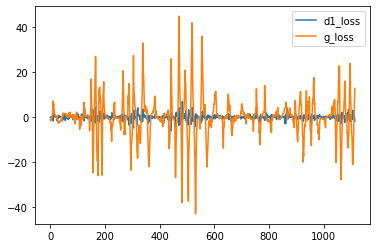

100%|██████████| 1115/1115 [01:31<00:00, 12.13it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/Models/plot_hist_3.png


100%|█████████▉| 1114/1115 [01:30<00:00, 15.59it/s]

[Epoch 9/50] [Batch 0/1115] [D loss: 1.445217] [G loss: 25.137104]


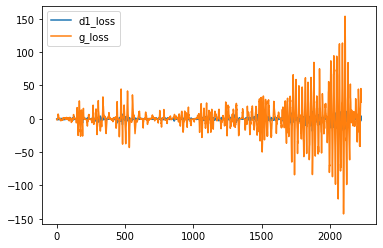

100%|██████████| 1115/1115 [01:31<00:00, 12.19it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/Models/plot_hist_3.png


100%|█████████▉| 1111/1115 [01:29<00:00, 12.11it/s]

[Epoch 14/50] [Batch 0/1115] [D loss: -3.790054] [G loss: 32.771233]


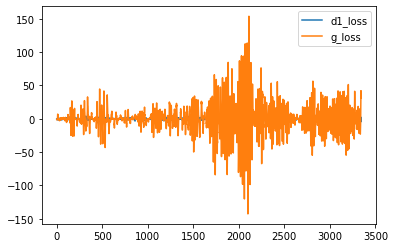

100%|██████████| 1115/1115 [01:29<00:00, 12.44it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/Models/plot_hist_3.png


100%|█████████▉| 1111/1115 [01:29<00:00, 12.11it/s]

[Epoch 19/50] [Batch 0/1115] [D loss: 0.363293] [G loss: -0.108084]


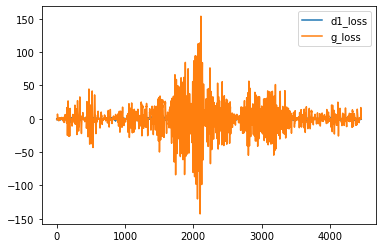

100%|██████████| 1115/1115 [01:29<00:00, 12.40it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/Models/plot_hist_3.png


100%|█████████▉| 1113/1115 [01:27<00:00, 13.11it/s]

[Epoch 24/50] [Batch 0/1115] [D loss: -1.533374] [G loss: -5.902048]


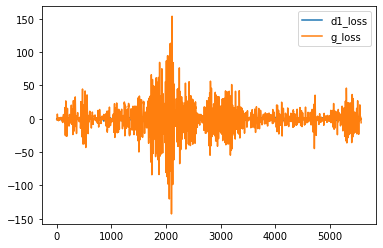

100%|██████████| 1115/1115 [01:28<00:00, 12.60it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/Models/plot_hist_3.png


100%|█████████▉| 1114/1115 [01:30<00:00, 15.24it/s]

[Epoch 29/50] [Batch 0/1115] [D loss: -0.259623] [G loss: 0.296682]


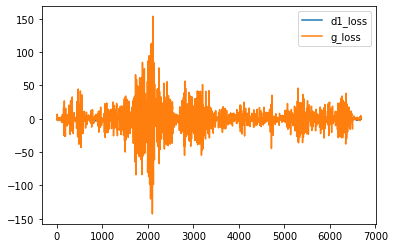

100%|██████████| 1115/1115 [01:31<00:00, 12.21it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/Models/plot_hist_3.png


100%|█████████▉| 1114/1115 [01:31<00:00, 15.15it/s]

[Epoch 34/50] [Batch 0/1115] [D loss: -2.121399] [G loss: 53.761578]


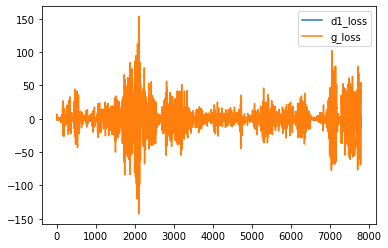

100%|██████████| 1115/1115 [01:32<00:00, 12.06it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/Models/plot_hist_3.png


100%|█████████▉| 1113/1115 [01:32<00:00, 12.28it/s]

[Epoch 39/50] [Batch 0/1115] [D loss: 0.214893] [G loss: 16.054426]


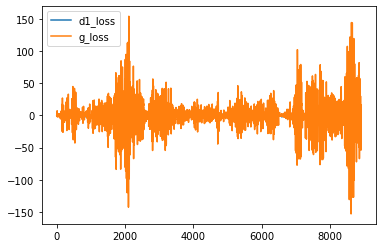

100%|██████████| 1115/1115 [01:32<00:00, 12.01it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/Models/plot_hist_3.png


100%|█████████▉| 1113/1115 [01:31<00:00, 13.46it/s]

[Epoch 44/50] [Batch 0/1115] [D loss: 0.310417] [G loss: -0.479323]


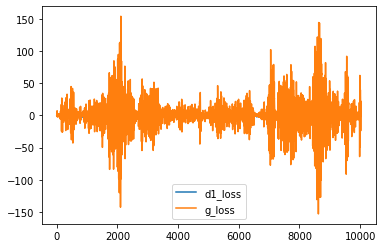

100%|██████████| 1115/1115 [01:31<00:00, 12.15it/s]


Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/Models/plot_hist_3.png


100%|█████████▉| 1113/1115 [01:32<00:00, 13.53it/s]

[Epoch 49/50] [Batch 0/1115] [D loss: -0.640537] [G loss: -1.258841]


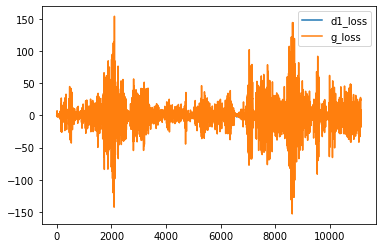

100%|██████████| 1115/1115 [01:32<00:00, 12.03it/s]

Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/Models/plot_hist_3.png


In [ ]:
save = True

generator = Generator()
discriminator = Discriminator()

if cuda:
  generator.cuda()
  discriminator.cuda()

optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

if (not (os.path.exists(models_path + "/WGAN_model150.tar"))):
  print("training of a new model")
  
  train_GAN(n_epochs=50, index=0)
  generator.eval()

else:
  print("resuming training from a loaded model")
  checkpoint = torch.load(models_path + "/WGAN_model150.tar")
  generator.load_state_dict(checkpoint['generator_state_dict'])
  discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
  optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
  optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

  #generator.eval()
  #discriminator.eval()

  train_GAN(n_epochs=50, index=3) #change index everytime

if(save):
   save_GAN()

In [ ]:
create_gif("/WGAN_GIF200.gif")

GIF correctly generated


#wrong code

##GIF first try

In [ ]:
import cv2

from numpy import linspace
from numpy import asarray
from numpy.random import randn

gif_path = "/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/GIF_Images"
os.makedirs(gif_path, exist_ok=True)

In [ ]:
z = Variable(Tensor(np.random.normal(0,1,(batch_size, latent_dim))))
for i in range(batch_size-1):
  interpolated = interpolate_points(z[i], z[i+1])

  interpolated = torch.stack([interpolated[0], interpolated[1], interpolated[2], interpolated[3], interpolated[4], interpolated[5], interpolated[6], 
                          interpolated[7], interpolated[8], interpolated[9]])

  gen_imgs = generator(interpolated)
  j = 0
  for img in gen_imgs.data:
    plt.figure(figsize=(2,2))
    new_img = img.to('cpu').detach().permute(1,2,0).numpy()
    save_image(img, f"{gif_path}/{i}.png", normalize=True)
    j = j + 1
    # new_img = cv2.resize(new_img, (32,32))
    plt.imshow(new_img)
    plt.axis("off")
    plt.show()

In [ ]:
def create_gif(n_gif,n_frame=10):
  gifs = []
  for i in range(n_gif):
    z = Variable(Tensor(np.random.normal(0,1,(2, latent_dim))))
    interpolated = interpolate_points(z[0], z[1],n_frame)

    interpolated = torch.stack([interpolated[0], interpolated[1], interpolated[2], interpolated[3], interpolated[4], interpolated[5], interpolated[6], 
                            interpolated[7], interpolated[8], interpolated[9]])

    gen_imgs = generator(interpolated)
    #j = 0
    gif = []
    for img in gen_imgs.data:
      #plt.figure(figsize=(2,2))
      new_img = img.to('cpu').detach().permute(1,2,0).numpy()
      #save_image(img, f"{gif_path}/{j}.png", normalize=True)
      #j = j + 1
      # new_img = cv2.resize(new_img, (32,32))
      #plt.imshow(new_img)
      #plt.axis("off")
      #plt.show()

      gif.append(new_img)
    gifs.append(gif)
    gifs = np.array(gifs)
    return gifs

##interpolation

In [ ]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
  # interpolate ratios between the points
  ratios = linspace(0, 1, num=n_steps)
  # linear interpolate vectors
  vectors = list()
  #vectors = torch.Tensor()
  for ratio in ratios:
    v = (1.0 - ratio) * p1 + ratio * p2
    vectors.append(v)
  
  return asarray(vectors)

##GIF

In [ ]:
import scipy

grid_size = [3, 3]
image_shrink = 1
image_zoom = 1
duration_sec = 5
smoothing_sec = 1.0
fps = 15
codec = 'libx264'
bitrate = '2M'#4M
random_seed = np.random.randint(0, 999)#405
filename = gif_path + '/random_grid_%s.gif' % random_seed
truncation_psi= 0.7

num_frames = int(np.rint(duration_sec * fps))
random_state = np.random.RandomState(random_seed)

# Generate latent vectors
#shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
#all_latents = random_state.randn(*shape).astype(np.float32)
#all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * fps] + [0] * len(Gs.input_shape), mode='wrap')
#all_latents /= np.sqrt(np.mean(np.square(all_latents)))


def create_image_grid(images, grid_size=None):
    #assert images.ndim == 3 or images.ndim == 4
    gifs,num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y : y + img_h, x : x + img_w] = images[idx]
    return grid

# Frame generation func for moviepy.
def make_frame(t):
    #frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    #latents = all_latents[frame_idx]
    #fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    #images = Gs.run(latents, None, truncation_psi=truncation_psi,
    #                      randomize_noise=False, output_transform=fmt, 
    #                      minibatch_size=16)
    images = create_gif(15)
    grid = create_image_grid(images, grid_size)
    if image_zoom > 1:
        grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
    if grid.shape[2] == 1:
        grid = grid.repeat(3, 2) # grayscale => RGB
    return grid

# Generate video.
import moviepy.editor
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

video_clip.write_gif(filename,fps=15)

In [ ]:
from IPython import display as ipythondisplay
import io
import os
import base64
from IPython.display import HTML

def show_video(vid):
  #mp4list = [video
  #if len(mp4list) > 0:
  ext = os.path.splitext(vid)[-1][1:]
  video = io.open(vid, 'r+b').read()
  #encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
              loop controls style="height: 400px;">
              <source src="data:video/{1}';base64,{0}" type="video/{1}" />
              </video>'''.format(base64.b64encode(video).decode('ascii'), ext)))
  
show_video(filename)

##GIF second try

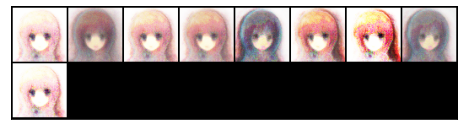


[MoviePy] Building file /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/GIF_Images/random_grid_703.gif with imageio


  0%|          | 0/76 [00:00<?, ?it/s]

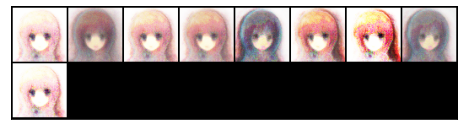

  1%|▏         | 1/76 [00:00<00:21,  3.42it/s]

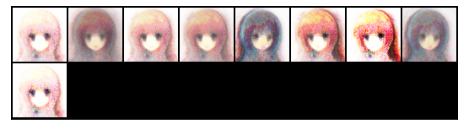

  3%|▎         | 2/76 [00:00<00:14,  5.21it/s]

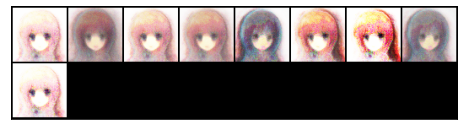

  4%|▍         | 3/76 [00:00<00:13,  5.59it/s]

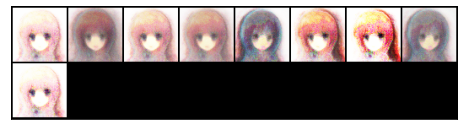

  5%|▌         | 4/76 [00:00<00:11,  6.39it/s]

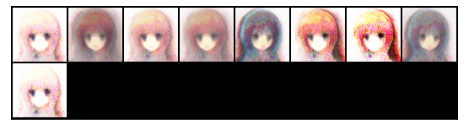

  7%|▋         | 5/76 [00:00<00:10,  7.00it/s]

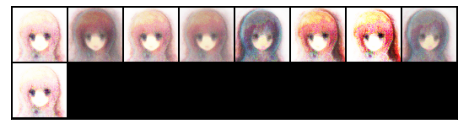

  8%|▊         | 6/76 [00:00<00:09,  7.23it/s]

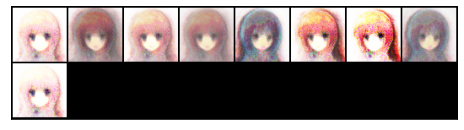

  9%|▉         | 7/76 [00:01<00:09,  7.18it/s]

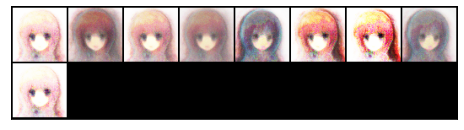

 11%|█         | 8/76 [00:01<00:09,  7.16it/s]

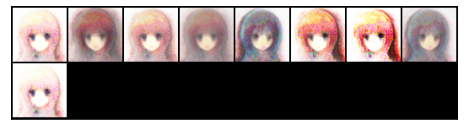

 12%|█▏        | 9/76 [00:01<00:09,  7.13it/s]

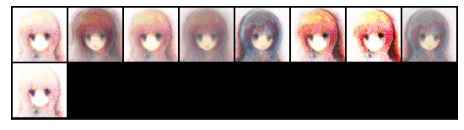

 13%|█▎        | 10/76 [00:01<00:09,  6.90it/s]

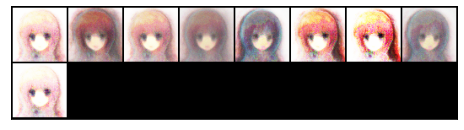

 14%|█▍        | 11/76 [00:01<00:10,  6.42it/s]

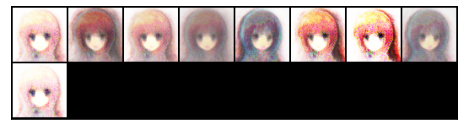

 16%|█▌        | 12/76 [00:01<00:09,  6.65it/s]

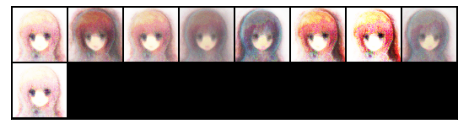

 17%|█▋        | 13/76 [00:01<00:09,  6.82it/s]

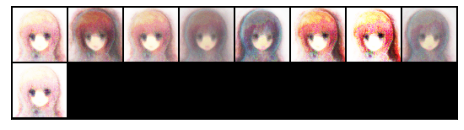

 18%|█▊        | 14/76 [00:02<00:09,  6.83it/s]

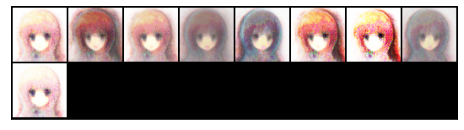

 20%|█▉        | 15/76 [00:02<00:08,  6.87it/s]

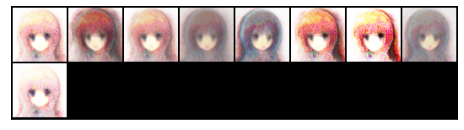

 21%|██        | 16/76 [00:02<00:09,  6.54it/s]

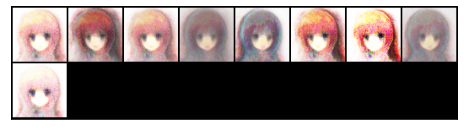

 22%|██▏       | 17/76 [00:02<00:08,  6.60it/s]

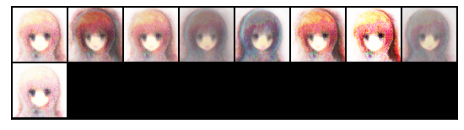

 24%|██▎       | 18/76 [00:02<00:08,  6.85it/s]

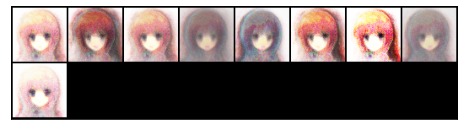

 25%|██▌       | 19/76 [00:02<00:08,  6.99it/s]

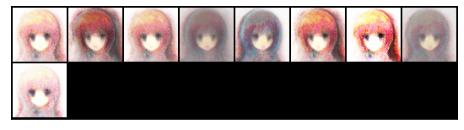

 26%|██▋       | 20/76 [00:02<00:07,  7.10it/s]

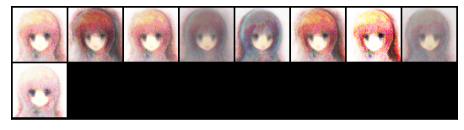

 28%|██▊       | 21/76 [00:03<00:07,  7.06it/s]

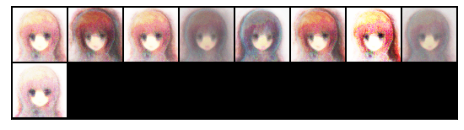

 29%|██▉       | 22/76 [00:03<00:07,  7.15it/s]

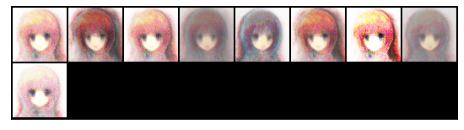

 30%|███       | 23/76 [00:03<00:07,  6.89it/s]

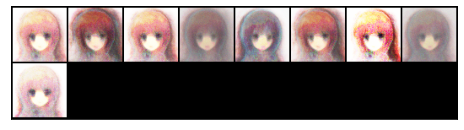

 32%|███▏      | 24/76 [00:03<00:07,  6.78it/s]

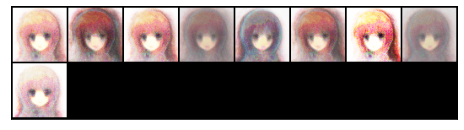

 33%|███▎      | 25/76 [00:03<00:07,  6.69it/s]

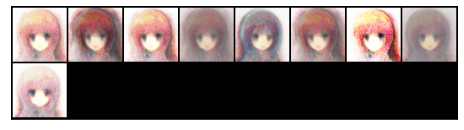

 34%|███▍      | 26/76 [00:03<00:08,  6.20it/s]

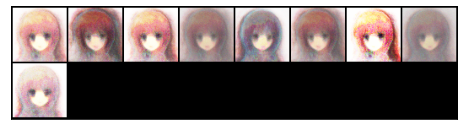

 36%|███▌      | 27/76 [00:04<00:07,  6.39it/s]

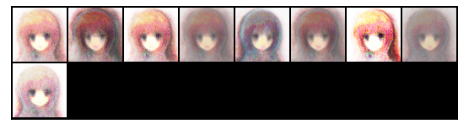

 37%|███▋      | 28/76 [00:04<00:07,  6.68it/s]

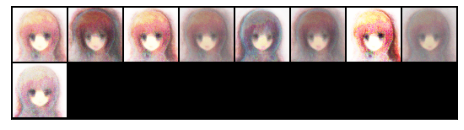

 38%|███▊      | 29/76 [00:04<00:06,  6.81it/s]

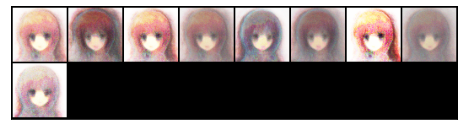

 39%|███▉      | 30/76 [00:04<00:06,  6.77it/s]

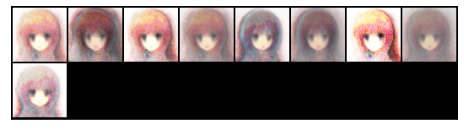

 41%|████      | 31/76 [00:04<00:06,  6.71it/s]

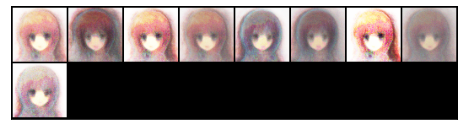

 42%|████▏     | 32/76 [00:04<00:06,  6.83it/s]

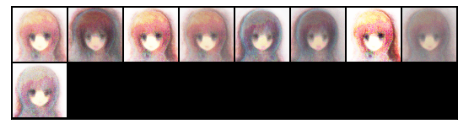

 43%|████▎     | 33/76 [00:05<00:08,  4.84it/s]

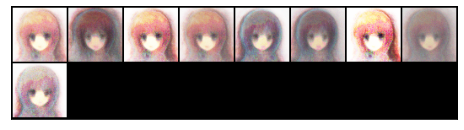

 45%|████▍     | 34/76 [00:05<00:07,  5.40it/s]

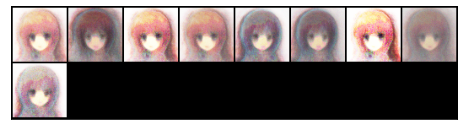

 46%|████▌     | 35/76 [00:05<00:07,  5.78it/s]

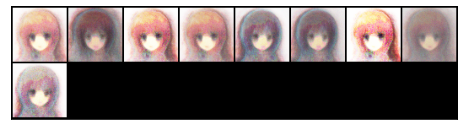

 47%|████▋     | 36/76 [00:05<00:06,  6.11it/s]

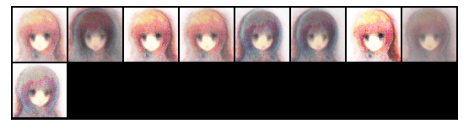

 49%|████▊     | 37/76 [00:05<00:06,  6.39it/s]

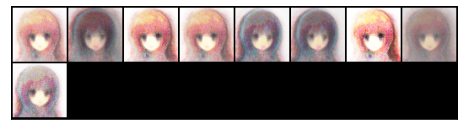

 50%|█████     | 38/76 [00:05<00:05,  6.41it/s]

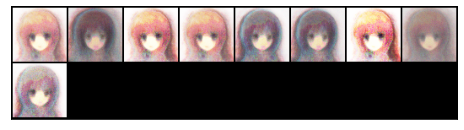

 51%|█████▏    | 39/76 [00:06<00:05,  6.49it/s]

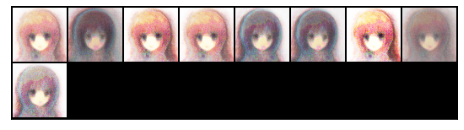

 53%|█████▎    | 40/76 [00:06<00:05,  6.46it/s]

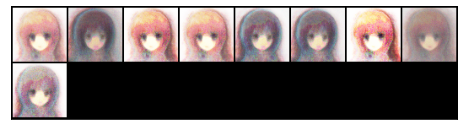

 54%|█████▍    | 41/76 [00:06<00:05,  6.55it/s]

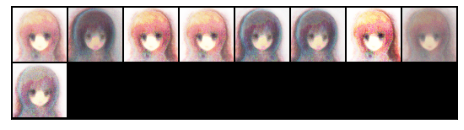

 55%|█████▌    | 42/76 [00:06<00:05,  6.64it/s]

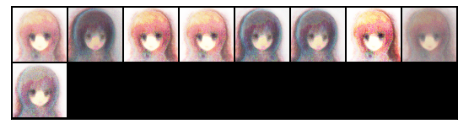

 57%|█████▋    | 43/76 [00:06<00:05,  6.58it/s]

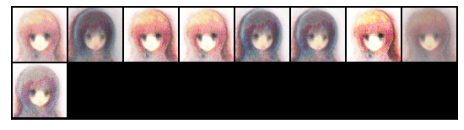

 58%|█████▊    | 44/76 [00:06<00:04,  6.40it/s]

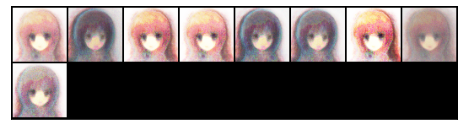

 59%|█████▉    | 45/76 [00:06<00:04,  6.34it/s]

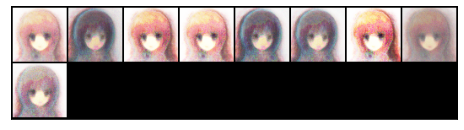

 61%|██████    | 46/76 [00:07<00:04,  6.27it/s]

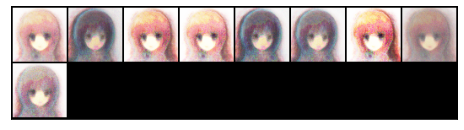

 62%|██████▏   | 47/76 [00:07<00:04,  6.25it/s]

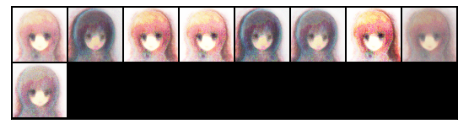

 63%|██████▎   | 48/76 [00:07<00:04,  6.04it/s]

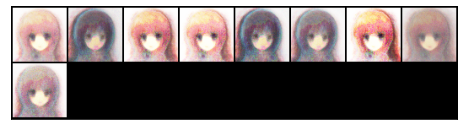

 64%|██████▍   | 49/76 [00:07<00:04,  6.04it/s]

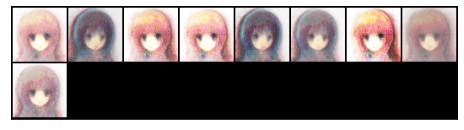

 66%|██████▌   | 50/76 [00:07<00:04,  6.24it/s]

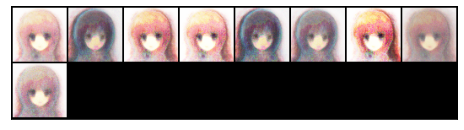

 67%|██████▋   | 51/76 [00:07<00:03,  6.42it/s]

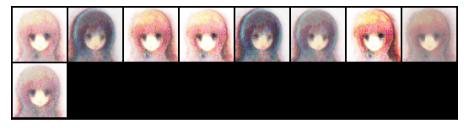

 68%|██████▊   | 52/76 [00:08<00:03,  6.37it/s]

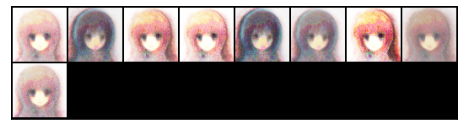

 70%|██████▉   | 53/76 [00:08<00:03,  6.36it/s]

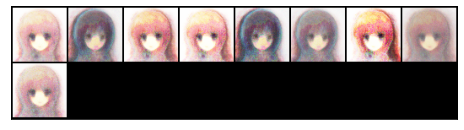

 71%|███████   | 54/76 [00:08<00:03,  6.28it/s]

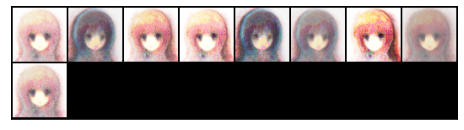

 72%|███████▏  | 55/76 [00:08<00:03,  6.34it/s]

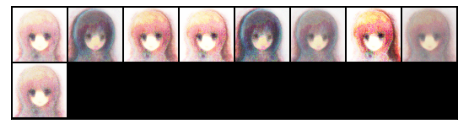

 74%|███████▎  | 56/76 [00:08<00:03,  6.25it/s]

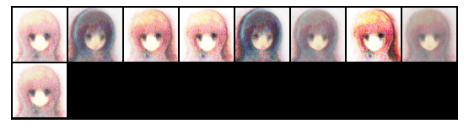

 75%|███████▌  | 57/76 [00:08<00:03,  6.23it/s]

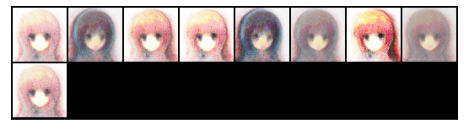

 76%|███████▋  | 58/76 [00:09<00:02,  6.34it/s]

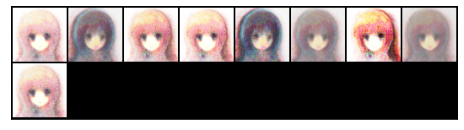

 78%|███████▊  | 59/76 [00:09<00:02,  6.41it/s]

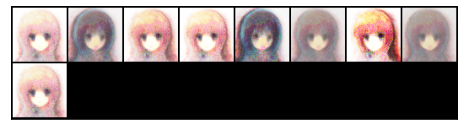

 79%|███████▉  | 60/76 [00:09<00:02,  6.35it/s]

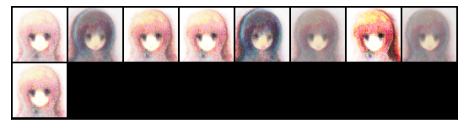

 80%|████████  | 61/76 [00:09<00:02,  6.24it/s]

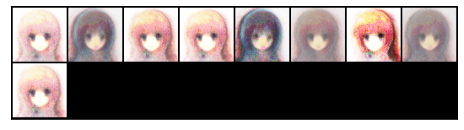

 82%|████████▏ | 62/76 [00:09<00:02,  6.29it/s]

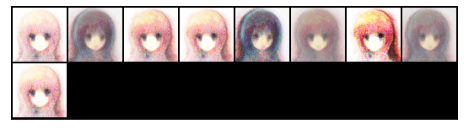

 83%|████████▎ | 63/76 [00:09<00:02,  6.30it/s]

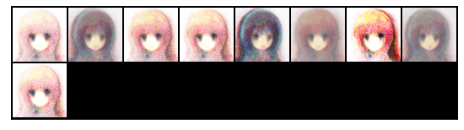

 84%|████████▍ | 64/76 [00:09<00:01,  6.11it/s]

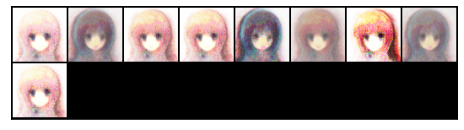

 86%|████████▌ | 65/76 [00:10<00:02,  4.12it/s]

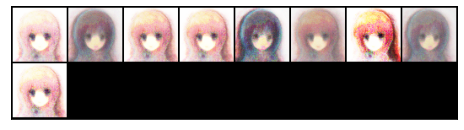

 87%|████████▋ | 66/76 [00:10<00:02,  4.04it/s]

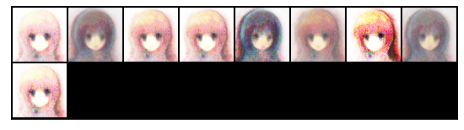

 88%|████████▊ | 67/76 [00:10<00:01,  4.56it/s]

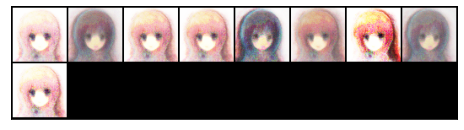

 89%|████████▉ | 68/76 [00:10<00:01,  4.87it/s]

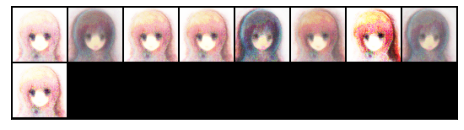

 91%|█████████ | 69/76 [00:11<00:01,  5.17it/s]

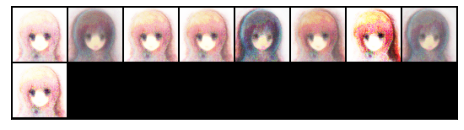

 92%|█████████▏| 70/76 [00:11<00:01,  5.37it/s]

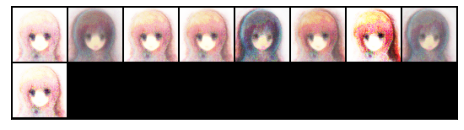

 93%|█████████▎| 71/76 [00:11<00:00,  5.60it/s]

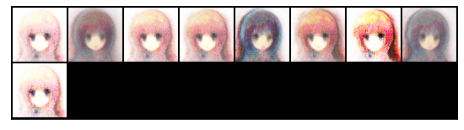

 95%|█████████▍| 72/76 [00:11<00:00,  5.55it/s]

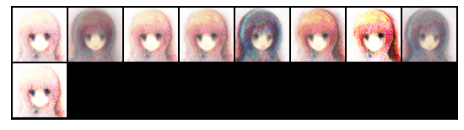

 96%|█████████▌| 73/76 [00:11<00:00,  5.70it/s]

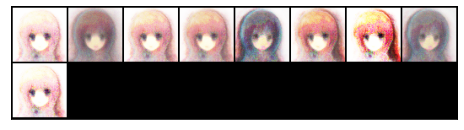

 97%|█████████▋| 74/76 [00:11<00:00,  5.82it/s]

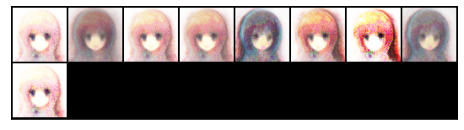

 99%|█████████▊| 75/76 [00:12<00:00,  6.17it/s]


In [ ]:
import scipy
import scipy.ndimage
import numpy as np
gif_path = "/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN/GIF_Images"

grid_size = [3, 3]
image_shrink = 1
image_zoom = 1
duration_sec = 5
smoothing_sec = 1.0
fps = 15
codec = 'libx264'
bitrate = '2M'#4M
random_seed = np.random.randint(0, 999)#405
filename = gif_path + '/random_grid_%s.gif' % random_seed
truncation_psi= 0.7

num_frames = int(np.rint(duration_sec * fps))
random_state = np.random.RandomState(random_seed)

# Generate latent vectors
shape = [num_frames, np.prod(grid_size)] + [latent_dim] # [frame, image, channel, component]
all_latents = random_state.randn(*shape).astype(np.float32)
all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * fps] + [0] * 2, mode='wrap')
all_latents /= np.sqrt(np.mean(np.square(all_latents)))
#print("latents shape" + str(all_latents.shape))

def create_image_grid(images, grid_size=None):
    assert images.ndim == 3 or images.ndim == 4
    num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    #grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=np.float32)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y : y + img_h, x : x + img_w] = images[idx]
    return grid

# Frame generation func for moviepy.
def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]
    #print("latents " + str(latents.shape))
    #fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    #images = Gs.run(latents, None, truncation_psi=truncation_psi,
    #                      randomize_noise=False, output_transform=fmt, 
    #                      minibatch_size=16)
    #print(latents)
    GANINPUT = torch.stack([torch.from_numpy(latents[0]), torch.from_numpy(latents[1]), torch.from_numpy(latents[2]), torch.from_numpy(latents[3]),
                            torch.from_numpy(latents[4]), torch.from_numpy(latents[5]), torch.from_numpy(latents[6]), 
                            torch.from_numpy(latents[7]), torch.from_numpy(latents[8])])

    images = generator(GANINPUT)
    show_images(images)
    plt.show()
    img = images.detach().cpu().permute(0,2,3,1).numpy()
    #print("imgshape" + str(img.shape))
    grid = create_image_grid(img, grid_size)
    #print("grid "+ str(grid.shape))
    if image_zoom > 1:
        grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
    if grid.shape[2] == 1:
        grid = grid.repeat(3, 2) # grayscale => RGB
    return grid

# Generate video.
import moviepy.editor
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

video_clip.write_gif(filename,fps=15)

NameError: ignored

In [ ]:
from IPython import display as ipythondisplay
import io
import os
import base64
from IPython.display import HTML

def show_video(vid):
  #mp4list = [video
  #if len(mp4list) > 0:
  ext = os.path.splitext(vid)[-1][1:]
  video = io.open(vid, 'r+b').read()
  #encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
              loop controls style="height: 400px;">
              <source src="data:video/{1}';base64,{0}" type="video/{1}" />
              </video>'''.format(base64.b64encode(video).decode('ascii'), ext)))
  
show_video(filename)